In [3]:
%matplotlib inline
import os

import jplus
#jplus_dir         =  '/home/CEFCA/aaorsi/work/j-plus/'
redmapper_dir     = '/home/CEFCA/aaorsi/work/redmapper/'
redmapperdata     = redmapper_dir + 'redmapper_dr8_public_v6.3_catalog.fits'
#tilesdata         = '%s/tiles/tiles_data_new.tsv' % elg_analysis_dir

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits

#import elg_analysis as elg
import elgtools as tools_elg
import learn_elgs as learn_elg
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

tile_scale = 1.40

rmin = -2
rmax =np.log10(tile_scale/2.)
nbins = 20

rarr = np.linspace(rmin, rmax, nbins)
dr = rarr[1] - rarr[0]

#t_info = np.loadtxt(tilesdata) ## Old tile list info, don't use
#print 'tiles info read'
tiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)


j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_dr1_dual.h5


In [4]:
from functools import reduce
def get_distance(ra1, dec1, ra2, dec2):
  ra1 *= np.pi/180.
  ra2 *= np.pi/180.
  dec1 *= np.pi/180.
  dec2 *= np.pi/180.
  
# Angular distance for two sets of coordinates
  cosg = (np.cos(np.pi/2. - dec1)*np.cos(np.pi/2. - dec2) +
          np.sin(np.pi/2. - dec1)*np.sin(np.pi/2.-dec2)*np.cos(ra1 - ra2))
  
  return np.arccos(cosg)


def quick_dist(ra1, dec1, ra2, dec2, units='deg'):
  return np.sqrt( ((ra1 - ra2)*np.cos(dec1*np.pi/180))**2 + (dec1 - dec2)**2)

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees


def skydist(ra1,dec1,ra2,dec2, units='deg'):
  
  n2 = len(ra2)

  if n2 != len(dec2):
    raise ValueError('ra, dec arrays have different number of elements')
  
  dist = np.zeros(n2)

  c1 = SkyCoord(ra1,dec1,unit=units)
  for i in range(n2):
    c2 = SkyCoord(ra2[i], dec2[i], unit=units)
    dist[i] = c1.separation(c2).radian

  return dist


  
def get_density(datadic, tiles, weights, dfunc = haversine_dist):  
  
  gal_arr = np.zeros(nbins)
  central = datadic['central']
  elgs    = datadic['elgs']
  ncentral  = len(central['ra'])
    
  # dfunc = quick_dist  # Define which distance calculator to use
  # dfunc = haversine_dist # get_distance  # Define which distance calculator to use
  
  print 'central objects loaded, %d clusters' % ncentral

  # Select only those central objects 
  # near a J-PLUS tile
  
  
  elgtiles = np.unique(elgs['tile_id'])
        
  ntiles = len(elgtiles)
  print 'ELG sample is contained in %d tiles' % ntiles
  print 'scanning tiles..'
 
  ktot = 0
  wtot = 0.0
  for i in range(ncentral):
    idc = i
    dist = dfunc(central['ra'][idc], central['dec'][idc], tiles['ra'], 
                tiles['dec'])
    idist = np.argmin(dist)
    mindist = dist[idist]

    if mindist < tile_scale:
      idtt = np.where(elgtiles == tiles['tileIDs'][idist])[0] # Tile with central obj contains ELGs
      
      if len(idtt) != 1:
        continue # len(idtt) = 0 would mean that this tile is empty -- not observed or bad photometry

      iw = weights[idist]  
      sel_tile = np.where(elgs['tile_id'] == tiles['tileIDs'][idist])[0]
      ngals = len(sel_tile)
  
      ktot += 1.0 # Tile contains central galaxy + ELGs around it.
      wtot += iw
      for k in range(ngals):
        idg = sel_tile[k]
        dist = np.log10(dfunc(central['ra'][idc], central['dec'][idc], 
        elgs['coords'][idg,0], elgs['coords'][idg,1]))

        if dist < rmax:
          dbin = int((dist  - rmin)/dr)
          gal_arr[dbin:] += iw

#    if ktot == 79:
#      break

  print gal_arr/ktot/wtot

  print 'N centers: ',ktot
  return gal_arr/ktot


def plot_densities(d1,label):
  import matplotlib.pyplot as plt
  vol_r = 1 #np.pi*(10**rarr)**2

  for d, l in zip(d1, label):
      plt.semilogy(rarr, d/vol_r,label=l,linewidth=3)

  plt.legend(fontsize=20, loc='upper left')

  plt.xlabel(r'$\log(\theta [{\rm deg}])$',fontsize=20)
  plt.ylabel(r'$\langle n \rangle (\leq r) [{\rm deg}^{-2}]$',fontsize=20)

  plt.xlim([rarr.min(),rarr.max()])
  #plt.ylim([np.min([d1v,d2v]), d2v.max()])

  plt.show()

  return 1


In [7]:
# A key function here:

def load_catalogues(elgfile = '', clusters = redmapperdata, random_mask='' , 
                    zrange=[.3,.35], find_tiles = False, tile_list = -1, 
                    tile_scale=1.40, crossmatch_all = True):

# if find_tiles, then central objects will be restricted to those within a tile. Thus, tile_list must contain a dictionary of tiles.

    if find_tiles and tile_list == -1:
        print 'load_catalogues() ERROR: Tiles needed in tile_list keyword'
        return {}
    
# Function to load elgs and redmapper catalogues

    elgs = pickle.load(open(elgfile))
    print 'ELG catalogue loaded'
    nelgs = len(elgs['tile_id'])
    raw_central = fits.open(clusters)
    central0     = raw_central[1].data
    zsel = np.where((central0['z_lambda'] > zrange[0]) & (central0['z_lambda'] < zrange[1]))[0]
    ncentral = len(zsel)
    central_ = central0[zsel]

    if find_tiles:
        cent = {'coords': np.asarray([ [central_['ra'][i], central_['dec'][i]] 
                                  for i in range(ncentral)])}
    
        d, ind = jplus.tools.crossmatch_angular(cent['coords'], tile_list['coords'], 
                                            max_distance=tile_scale*np.sqrt(2))
        m = (d != np.inf)
        print len(m)
        central = jplus.tools.select_object(cent, m)
        tiles_clusters = jplus.tools.select_object(tile_list, ind[m])
        central['tile_id'] = tiles_clusters['tile_id']
        
        Test_Tiles_XMatch = True
        if Test_Tiles_XMatch:
            # This will reproduce the above procedure on the ELGs to compare against their actual tile_id from the catalogue
            
            print tile_list['ra'][0:100]
            
            tile2 = np.zeros(nelgs)
            for i in range(nelgs):
                idt2 = np.argsort(haversine_dist(elgs['coords'][i,0], elgs['coords'][i,1], tile_list['ra'], tile_list['dec']))[0]  
                tile2[i] = tile_list['tile_id'][idt2]
            import matplotlib.pyplot as plt
            plt.plot(elgs['tile_id'], tile2,',')
            plt.show()
        
    if 'ra' not in central:
        central['ra'] = central['coords'][:,0]
        central['dec'] = central['coords'][:,1]
    
    
    print 'finding tile_id of random points...'
    nran = len(random_mask['coords'])
    ran_tile_id = np.zeros(nran)
    
    d, ind = jplus.tools.crossmatch_angular(random_mask['coords'], tile_list['coords'], 
                                            max_distance=tile_scale*np.sqrt(2))
    m = (d != np.inf)
    
    randict = jplus.tools.select_object(random_mask, m)
    tiles_ran = jplus.tools.select_object(tile_list, ind[m])
    randict['tile_id'] = tiles_ran['tile_id']
       
    if crossmatch_all:
        print 'Returning only ELGs, Redmapper clusters and random mask tiles with overlapping tiles'
        
        unique_tiles = reduce(np.intersect1d, (np.unique(elgs['tile_id']), 
                                               np.unique(central['tile_id']),
                                               np.unique(randict['tile_id'])))
        print 'intersecting tiles ', unique_tiles
        
        
        reduced_elgs     = jplus.tools.select_object(elgs, np.array([item in unique_tiles for item in elgs['tile_id'] ]))
        reduced_random   = jplus.tools.select_object(randict, np.array([item in unique_tiles for item in randict['tile_id'] ]))
        reduced_clusters = jplus.tools.select_object(central, np.array([item in unique_tiles for item in central['tile_id'] ]))
        reduced_tiles    = jplus.tools.select_object(tile_list, np.array([item in unique_tiles for item in tile_list['tile_id'] ]))
    
        out = {'elgs': reduced_elgs, 
              'clusters': reduced_clusters,
              'randoms': reduced_random,
              'tiles': reduced_tiles}
    else:
        out = {'elgs': elgs, 
              'clusters': central,
              'randoms': randict,
              'tiles': tile_list}
    
    return out


In [6]:
# Load catalogues
import pickle

elgfile = 'ELG_cand.data'
ranfile = 'random_mask.data'

#elgs = pickle.load(open(elgfile))
#ran = pickle.load(open(ranfile))

#print elgs.keys()
#print ran.keys()
#print 'Catalogues loaded OK'



Reading random mask file ...
ELG catalogue loaded
3650
[ 116.7072  116.7072  116.7072  116.7072  116.7072  116.7072  116.7072
  116.7072  116.7072  116.7072  116.7072  116.7072  256.5934  256.5934
  256.5934  256.5934  256.5934  256.5934  256.5934  256.5934  256.5934
  256.5934  256.5934  256.5934  256.7703  256.7703  256.7703  256.7703
  256.7703  256.7703  256.7703  256.7703  256.7703  256.7703  256.7703
  256.7703  258.3111  258.3111  258.3111  258.3111  258.3111  258.3111
  258.3111  258.3111  258.3111  258.3111  258.3111  258.3111  256.5089
  256.5089  256.5089  256.5089  256.5089  256.5089  256.5089  256.5089
  256.5089  256.5089  256.5089  256.5089  255.0013  255.0013  255.0013
  255.0013  255.0013  255.0013  255.0013  255.0013  255.0013  255.0013
  255.0013  255.0013  112.2039  112.2039  112.2039  112.2039  112.2039
  112.2039  112.2039  112.2039  112.2039  112.2039  112.2039  112.2039
  258.0164  258.0164  258.0164  258.0164  258.0164  258.0164  258.0164
  258.0164  258.0164  

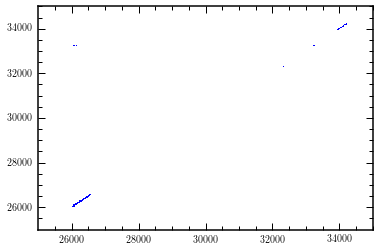

finding tile_id of random points...
Returning only ELGs, Redmapper clusters and random mask tiles with overlapping tiles
intersecting tiles  [26012 26013 26015 26018 26019 26020 26022 26023 26024 26025 26026 26028
 26029 26030 26031 26032 26033 26034 26035 26036 26037 26039 26040 26045
 26050 26051 26052 26055 26056 26057 26058 26061 26064 26066 26067 26068
 26070 26074 26077 26080 26087 26088 26092 26093 26097 26098 26099 26102
 26104 26105 26108 26112 26113 26127 26129 26131 26133 26136 26139 26140
 26141 26142 26144 26159 26170 26171 26173 26180 26181 26185 26188 26189
 26190 26191 26192 26195 26196 26198 26201 26204 26205 26206 26207 26208
 26210 26212 26214 26215 26216 26221 26222 26223 26224 26225 26227 26234
 26235 26239 26241 26242 26245 26249 26250 26253 26254 26256 26261 26269
 26276 26278 26279 26281 26282 26284 26285 26286 26287 26288 26289 26290
 26291 26292 26293 26297 26298 26299 26302 26324 26326 26328 26330 26332
 26333 26334 26336 26337 26339 26341 26343 26345 26347 2

In [8]:

#def elg_clusters():
import pymangle
CreateRandoms = False # False implies reading them from a file
RanFile = 'random_mask.data'

if CreateRandoms:
    print 'Creating random mask file...'
    ran = mask.create_random(3e5)
    print 'Nrandom: %ld' % nran
    with open(RanFile,'wb') as outfile:
        pickle.dump(randict,outfile,protocol=pickle.HIGHEST_PROTOCOL)
else:
    print 'Reading random mask file ...'
    ran = pickle.load(open(RanFile))


tcoords = {'coords': np.asarray([ [tiles['ra'][i], tiles['dec'][i]] for i in range(len(tiles['ra'])) ]),
          'tile_id': tiles['ref_tileID'],
          'ra': tiles['ra'],
          'dec':tiles['dec']}

mastercat = load_catalogues(elgfile=elgfile, clusters= redmapperdata, 
                            find_tiles=True, tile_list=tcoords,random_mask=ran)


tcenter = {'ra':tiles['ra'], 'dec':tiles['dec']}
#tilecat = load_catalogues(elgfile=elgfile,centralobj=tcenter, centralobjtype='')

#elgs = mastercat['elgs']
     

   
                
#good = mask.contains(elgs['coords'])


mask_clusters = {}  # Randoms around clusters
mask_clusters['elgs'] = mastercat['randoms']
mask_clusters['central'] = mastercat['clusters']


mask_tile = {}     # Randoms around tile centres
mask_tile['elgs'] = mastercat['randoms']
mask_tile['central'] = mastercat['tiles']


elgs_tile = {}     # ELGs around tiles
elgs_tile['elgs'] = mastercat['elgs']
elgs_tile['central'] = mastercat['tiles']


  

In [9]:
print tiles.keys()

['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']


In [10]:
print tiles['ref_tileID'], tiles['tileIDs']

print elgs['SQL_query']


[25998 25998 25998 ..., 34197 34197 34197] [26006 26002 26003 ..., 34228 34229 34084]


NameError: name 'elgs' is not defined

In [11]:
import pickle
elgs = pickle.load(open(elgfile))
ngal = len(elgs['tile_id'])
print ngal
print len(tiles['tileIDs'])

print tiles['tileIDs'][0:10]

for i in range(ngal):
    elgtile = elgs['tile_id'][i]
    elgc = elgs['coords'][i]
    idt = np.where(tiles['tileIDs'] == elgtile)
    
    within_tile = map(lambda min_ra, max_ra, min_dec, max_dec: (elgc[0]>min_ra) & (elgc[1]<max_ra) & (elgc[1]>min_dec) & (elgc[1]<max_dec),
                     tiles['min_ra'], tiles['max_ra'], tiles['min_dec'], tiles['max_dec'])   
    
    idt2 = np.where(within_tile)[0]
    print i, tiles['ref_tileID'][idt2]
    
    #idt2 = np.argsort(quick_dist(elgs['coords'][i,0], elgs['coords'][i,1], tcoords['ra'], tcoords['dec']))[0]  
    tile2 = tcoords['tile_id'][idt2]
    print tile2 - elgtile

 
    
    

1425
6132
[26006 26002 26003 26009 26008 25998 26000 26001 26004 26005]
0 [26566 30211 31261 28120 31781 27596 29170 30737 27073 26017 28645 29695
 29172 30215 28646 29702 26019 27075 26568 27597 31262 31782 28122 30738
 27083 28131 26555 29179 28657 30224 30747 31274 31791 29700 26020 27605
 28656 28130 26561 26023 29701 31272 31790 30225 30746 29180 27604 27082
 31270 27603 26024 29699 27079 26569 30743 31787 28652 29176 30220 28127
 30216 31784 27602 30739 31265 29175 28124 26025 29697 27078 28647 26574
 27077 29173 28123 30741 31785 26026 29696 31264 30217 26571 27600 28648
 28126 28651 31267 30742 29178 29698 30219 26028 31786 27599 27081 26567
 31783 31263 30213 29174 30740 27598 29706 28649 26565 27076 26029 28125
 30663 28575 31709 30143 31194 29624 28047 29098 27004 26477 27526 32232
 27527 32233 29099 28048 29623 31192 27003 26478 30672 30144 28578 31718
 29101 26479 31716 32234 30675 27001 29622 28050 27529 30145 28576 31193
 29100 30147 28579 27007 28054 29631 30667 31195 3

j-plus [INFO]: Creating HealPix map
j-plus [INFO]: Saving HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]: Reading HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]:  Plotting in the range: lon = [-174.151749179,156.066817887], and lat = [1.27281051579,57.5352424155]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


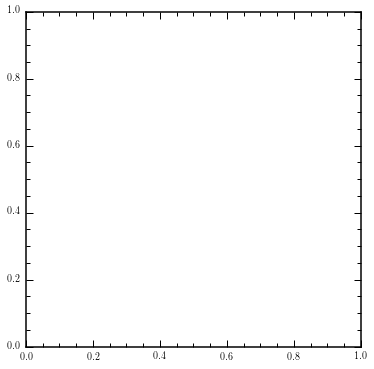

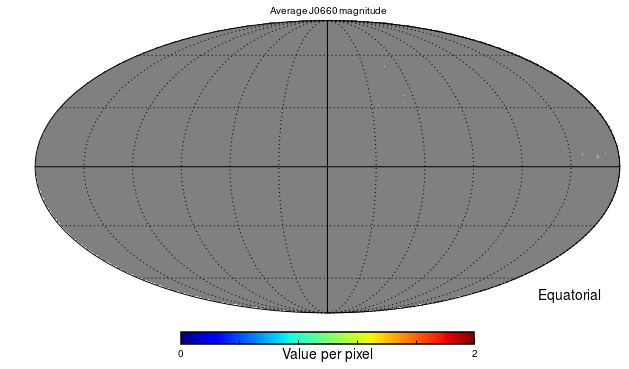

In [65]:
hp = jplus.healpix.HealpixMap(elgs['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

In [60]:
hp = jplus.healpix.HealpixMap(randict['coords'], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

NameError: name 'randict' is not defined

In [ ]:
print g4

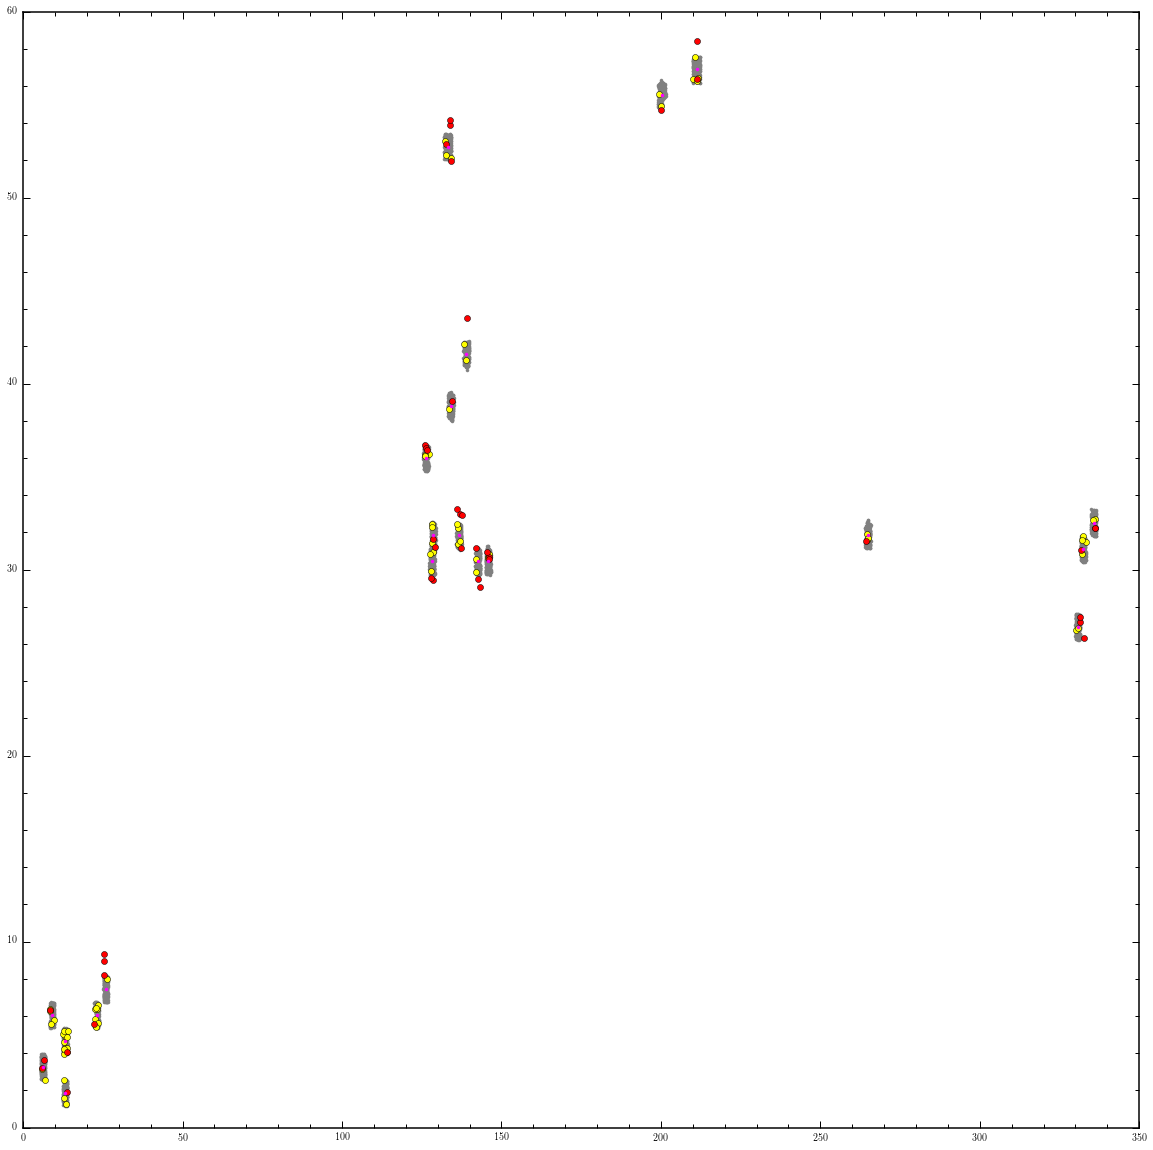

In [66]:
plt.figure(12)

ran      = mastercat['randoms']
elgs     = mastercat['elgs']
clusters = mastercat['clusters']
t2       = mastercat['tiles']
plt.rcParams['figure.figsize'] = 20, 20

plt.plot(ran['coords'][:,0],ran['coords'][:,1], '.',color='gray')
plt.plot(elgs['coords'][:,0],elgs['coords'][:,1], 'o',color='yellow')
#rm = mastercat['central']
plt.plot(clusters['coords'][:,0],clusters['coords'][:,1], 'o',color='red')
plt.plot(t2['ra'], t2['dec'], '.', color='magenta')
plt.show()



Number of tiles available: 6338
Number of tiles in groupby: 401


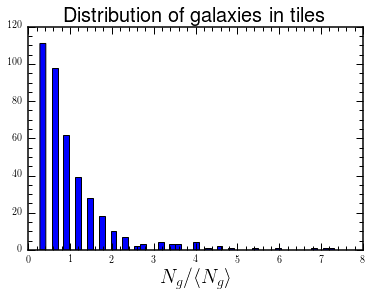

In [43]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
#print tile
#print mag
#print total

weights = np.asarray(total)/(np.mean(total)+0.0)
#print weights
ntile = len(tiles['tileIDs'])
#print tiles['tileIDs']

wtile = np.zeros(ntile)
k = 0
for itile in tiles['tileIDs']:
    idd = np.where(tile == itile)[0]
    if len(idd) == 1:
        wtile[k] = 1./weights[idd]
    else:
        wtile[k] = 0.0
    k +=1

#print wtile
#print len(np.where(wtile == 0)[0])/(ntile+0.0)

print 'Number of tiles available: %ld' % ntile
print 'Number of tiles in groupby: %ld' % len(tile)

plt.figure(666)

plt.hist(weights,bins=50)
plt.xlabel(r'$N_g/\langle N_g \rangle',fontsize=20)
plt.title('Distribution of galaxies in tiles',fontsize=20)



In [44]:


g1 = get_density(mastercat, tiles, wtile)
g2 = get_density(tilecat, tiles, wtile)

g3 = get_density(mask_clusters, tiles, wtile)
g4 = get_density(mask_tile, tiles, wtile)



central objects loaded, 357 clusters
ELG sample is contained in 401 tiles
scanning tiles..
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.00151515  0.00151515  0.0030303   0.00454545
  0.00454545  0.00757576  0.0094697   0.01287879  0.02045455  0.03257576
  0.03257576]
N centers:  24.0
central objects loaded, 6338 clusters
ELG sample is contained in 401 tiles
scanning tiles..
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.98631194e-05
   3.98631194e-05   3.98631194e-05   6.26420447e-05   1.42368283e-04
   2.22094522e-04   6.83057139e-04   1.32086705e-03   1.72476155e-03
   2.11536835e-03   2.93383930e-03   3.60735345e-03   3.60735345e-03]
N centers:  372.0
central objects loaded, 357 clusters
ELG sample is contained in 524 tiles
scanning tiles..
[  0.00000000e+00   2.04290092e-04   4.08580184e-04   6.12870276e-04
   1.02145046e-03   1.83861083e-03   2.

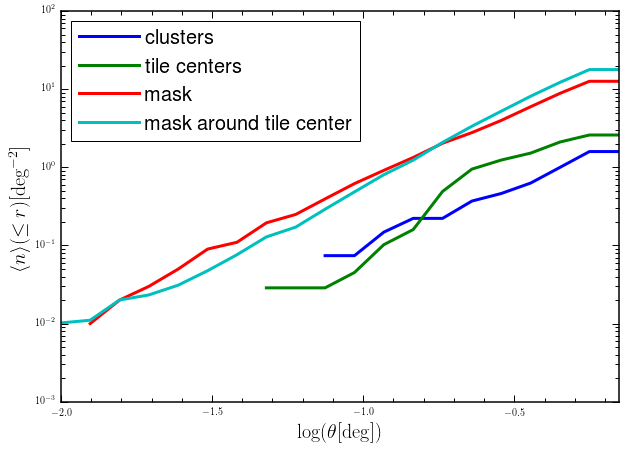

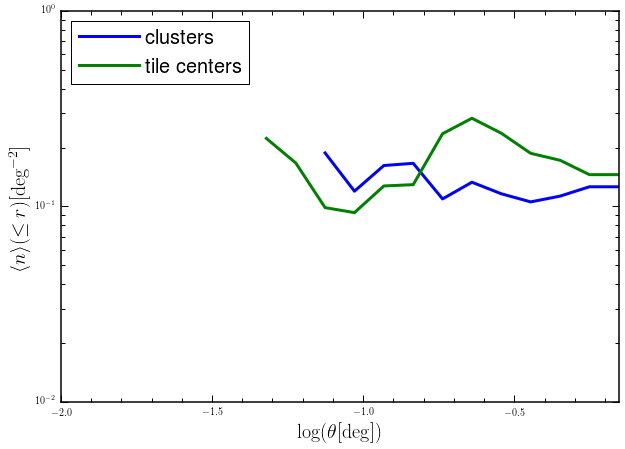

1

In [46]:
plt.rcParams['figure.figsize'] = 10, 7
plt.figure(11)
plot_densities([g1,g2,g3,g4],['clusters','tile centers', 'mask', 'mask around tile center'])
plt.figure(22)
plot_densities([g1/g3,g2/g4],['clusters','tile centers'])

26003
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  T

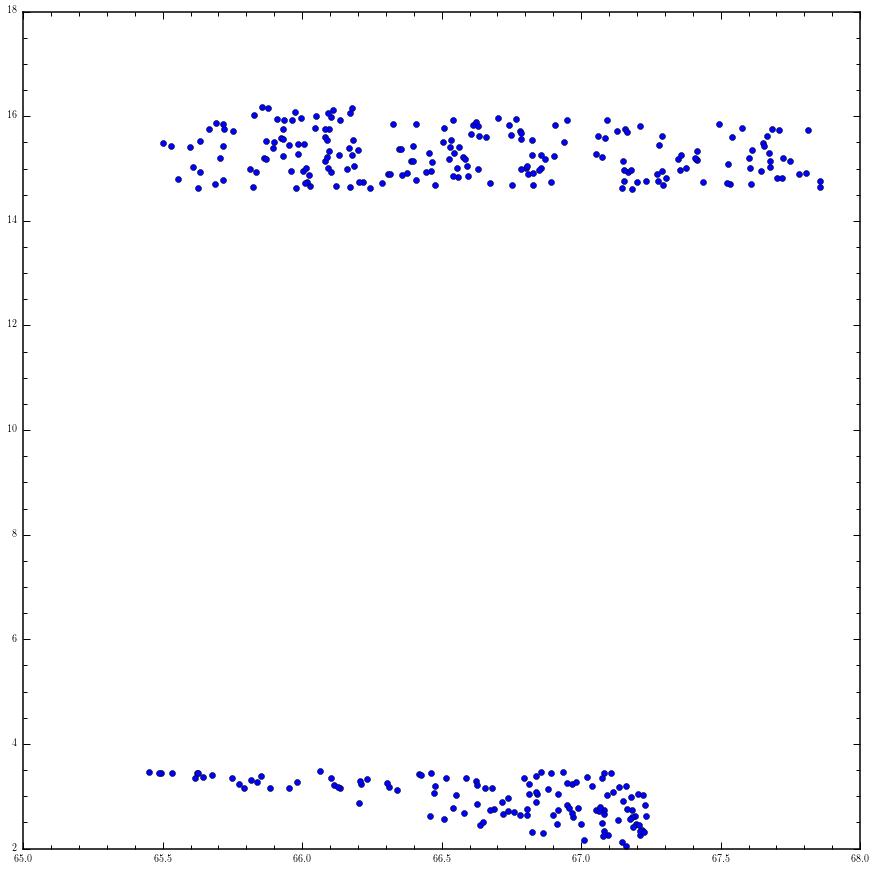

In [35]:
plt.figure()

tnumber = 0
tid = tiles['tileIDs'][tnumber]
print tid
mask = randict['tile_id'] == randict['tile_id'][0]
print mask[mask == True]
plt.plot(ran['coords'][mask,0]-tiles['ra'][tnumber],ran['coords'][mask,1]-tiles['dec'][tnumber],'o')

[33204, 33205, 33206, 33207, 33208, 33210, 33211, 33213, 33214, 33215, 33217, 33220, 33222, 33223, 33224, 33225, 33227, 33228, 33230, 33231, 33233, 33234, 33928, 33956, 33969, 33985, 33998, 34020, 34040, 34072, 34093, 34110, 34121, 34147, 34150, 34154, 34187, 25998, 34197, 26010, 26012, 26013, 26015, 26017, 26018, 26019, 26020, 26022, 26023, 26024, 26025, 26026, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26045, 26047, 26049, 26050, 26051, 26052, 26054, 26055, 26056, 26057, 26058, 26060, 26061, 26062, 26063, 26064, 26066, 26067, 26068, 26069, 26070, 26074, 26076, 26077, 26079, 26080, 26081, 26082, 26083, 26087, 26088, 26090, 26091, 26092, 26093, 26096, 26097, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26119, 26122, 26123, 26124, 26125, 26126, 26127, 26128, 26129, 26131, 26133, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26147, 26148, 26149, 26153

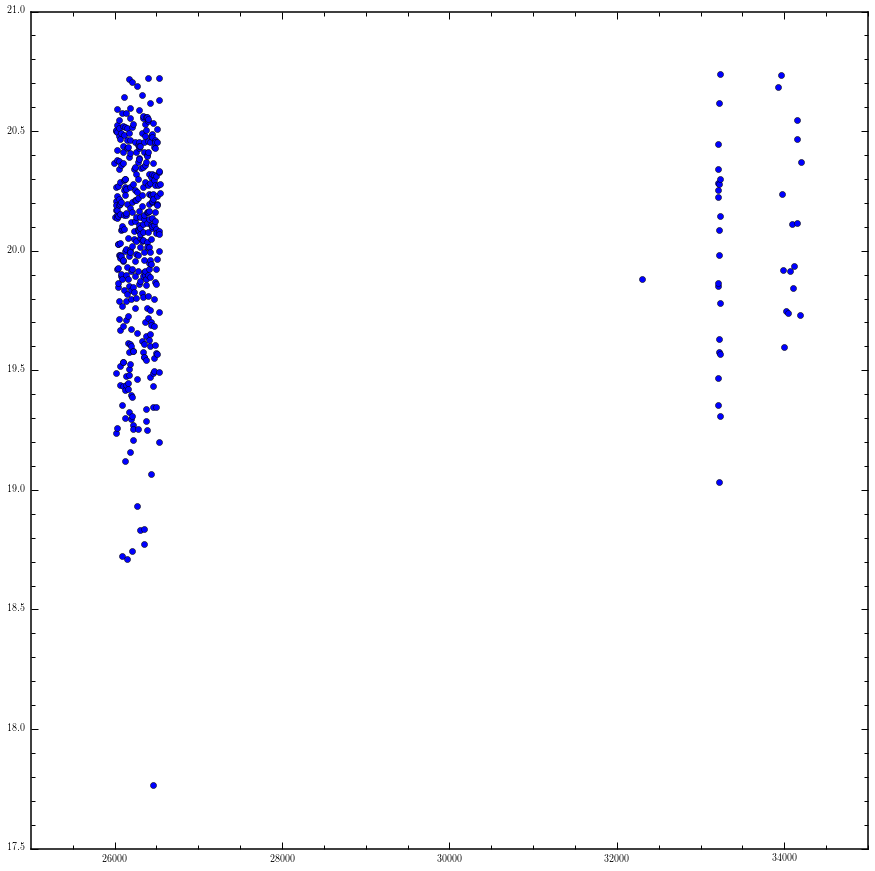

In [36]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
plt.figure()
plt.plot(tile, mag,'o')
print tile, total

In [37]:
len(elgs['tile_id'])


1425